In [1]:
# Imports
import numpy as np
import pandas as pd

from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import RFE
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.neighbors import KNeighborsRegressor

import matplotlib.pyplot as plt
import seaborn as sns


In [2]:
# Load data
df = pd.read_excel("data/Realized Schedule 20210101-20220208.xlsx")

# Remove rows with missing values
df.dropna(inplace=True)

print(df.head())

         ScheduleTime Airline  FlightNumber Destination AircraftType  \
0 2021-01-01 06:35:00      IA           874         DEN          73W   
1 2021-01-01 10:35:00      JZ           818         YHM          AT7   
2 2021-01-01 12:05:00      IA           876         DEN          73W   
3 2021-01-01 13:20:00      CN           514         EST          AT7   
4 2021-01-01 14:20:00      LJ          3140         DEN          32A   

  FlightType Sector  SeatCapacity  LoadFactor  
0          J     US           142    0.408451  
1          J     CA            74    0.189189  
2          J     US           142    0.570423  
3          J     US            72    0.333333  
4          J     US           186    0.204301  


### Analysis of the attributes

In [3]:
airlines = df['Airline'].unique()
print("Num airlines :", len(airlines))

flightnum = df['FlightNumber'].unique()
print("Num flight num :", len(flightnum))

aircraft = df['AircraftType'].unique()
print("Num aircraft type :", len(aircraft))

flighttype = df['FlightType'].unique()
print("Num flight type :", len(flighttype))

sectors = df['Sector'].unique()
print("Num sectors :", len(sectors))

seatcap = df['SeatCapacity'].unique()
print("Num seat capacities :", len(seatcap))

dest = df['Destination'].unique()
print("Num destinations :", len(dest))

Num airlines : 95
Num flight num : 807
Num aircraft type : 56
Num flight type : 3
Num sectors : 12
Num seat capacities : 132
Num destinations : 230


In [4]:
print(flighttype)
print(df[df['FlightType']=='G'])
print("We have one Flight with incorrect flight type")

['J' 'C' 'G']
             ScheduleTime Airline  FlightNumber Destination AircraftType  \
35822 2022-02-06 19:30:00      OF           575         OTH          32Q   

      FlightType Sector  SeatCapacity  LoadFactor  
35822          G     US           160     0.45625  
We have one Flight with incorrect flight type


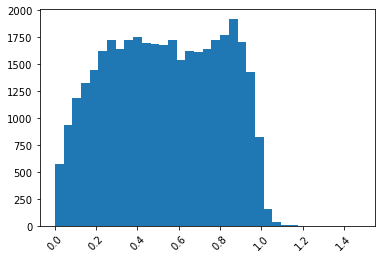

In [5]:
count = df['LoadFactor'].count()
bn = int(1 + 3.322*np.log(count))

plt.hist(df['LoadFactor'], bins = bn)
plt.xticks(rotation=45)
#plt.set_title("Histogram of load factors over all flights")
plt.show()

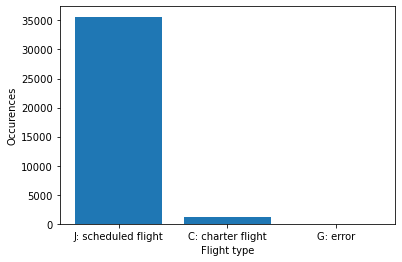

In [6]:
per_flighttype = [None for _ in range(len(flighttype))]
for i,tp in enumerate(flighttype):
    per_flighttype[i] = df[df.FlightType == tp].shape[0]

fig, ax = plt.subplots(1, 1)
plt.bar(["J: scheduled flight", "C: charter flight", "G: error"], per_flighttype)
ax.set_xlabel("Flight type")
ax.set_ylabel("Occurences")
plt.show()

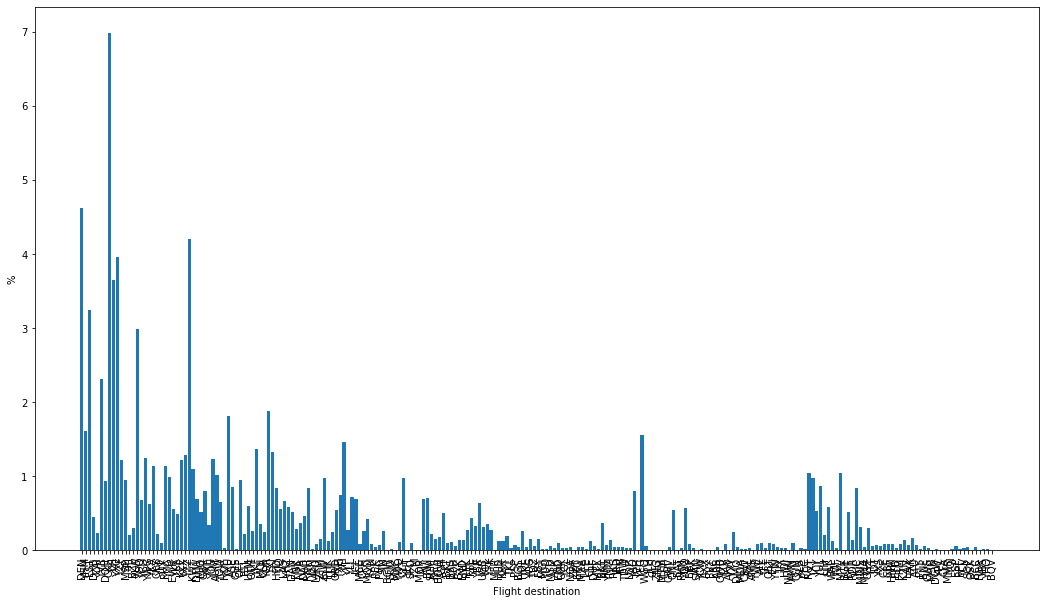

In [7]:
tt_flights = df.shape[0]

per_dest = [None for _ in range(len(dest))]
for i,destination in enumerate(dest):
    per_dest[i] = df[df.Destination == destination].shape[0]/tt_flights*100

fig, ax = plt.subplots(1, 1, figsize=(18,10))
plt.bar(dest, per_dest)
plt.xticks(rotation=90)
ax.set_xlabel("Flight destination")
ax.set_ylabel("%")
plt.show()

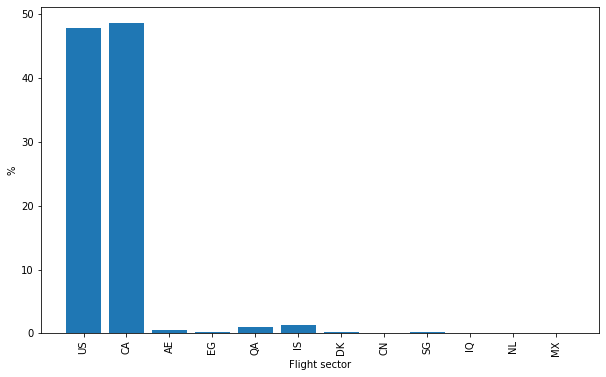

In [8]:
per_sect = [None for _ in range(len(sectors))]
for i,sect in enumerate(sectors):
    per_sect[i] = df[df.Sector == sect].shape[0]/tt_flights*100

fig, ax = plt.subplots(1, 1, figsize=(10,6))
plt.bar(sectors, per_sect)
plt.xticks(rotation=90)
ax.set_xlabel("Flight sector")
ax.set_ylabel("%")
plt.show()

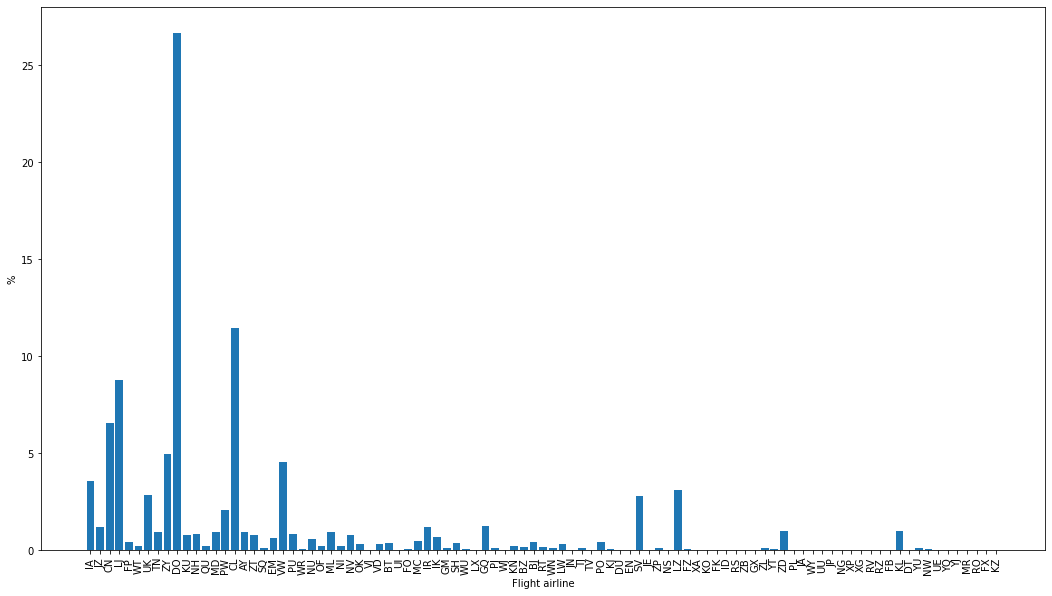

In [9]:
per_airline = [None for _ in range(len(airlines))]
for i,airline in enumerate(airlines):
    per_airline[i] = df[df.Airline == airline].shape[0]/tt_flights*100

fig, ax = plt.subplots(1, 1, figsize=(18,10))
plt.bar(airlines, per_airline)
plt.xticks(rotation=90)
ax.set_xlabel("Flight airline")
ax.set_ylabel("%")
plt.show()

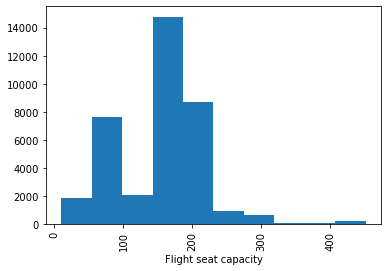

In [10]:
fig, ax = plt.subplots(1, 1)
plt.hist(df.SeatCapacity)
plt.xticks(rotation=90)
ax.set_xlabel("Flight seat capacity")
plt.show()

[18, 0, 4, 6, 17, 691, 2152, 2774, 2753, 2056, 1903, 2253, 2520, 2298, 2313, 2287, 2396, 2569, 2295, 1854, 1604, 1103, 615, 287]


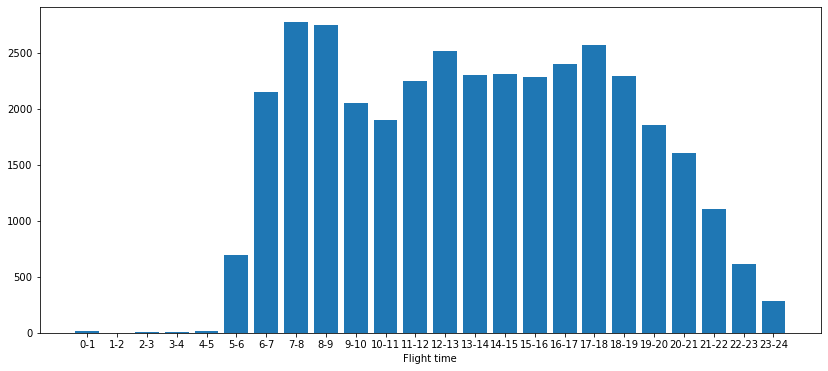

In [11]:
time = [None for i in range(24)]

hours = pd.to_datetime(df['ScheduleTime']).dt.hour

for i in range(24):
    def good_hour(x):
        return x == i
    
    time[i] = len(list(filter(good_hour, hours)))

print(time)
    
fig, ax = plt.subplots(1, 1, figsize=(14, 6))
plt.bar([str(i) + "-" + str(i+1) for i in range(24)], time)
ax.set_xlabel("Flight time")
plt.show()

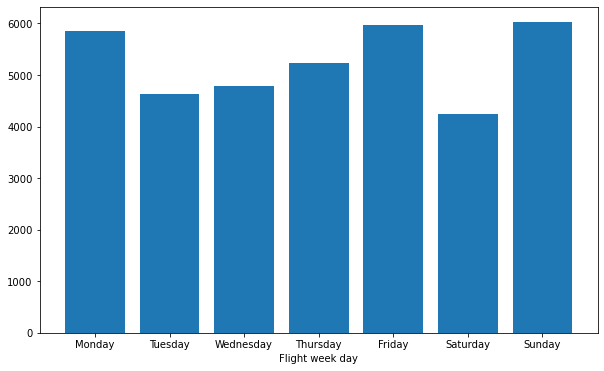

In [12]:
weekDays = pd.to_datetime(df.ScheduleTime).dt.weekday
per_wd = [None for i in range(7)]

for i in range(7):
    def good_day(x):
        return x == i
    
    per_wd[i] = len(list(filter(good_day, weekDays)))
    
fig, ax = plt.subplots(1, 1, figsize=(10, 6))
plt.bar(["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"], per_wd)
ax.set_xlabel("Flight week day")
plt.show()

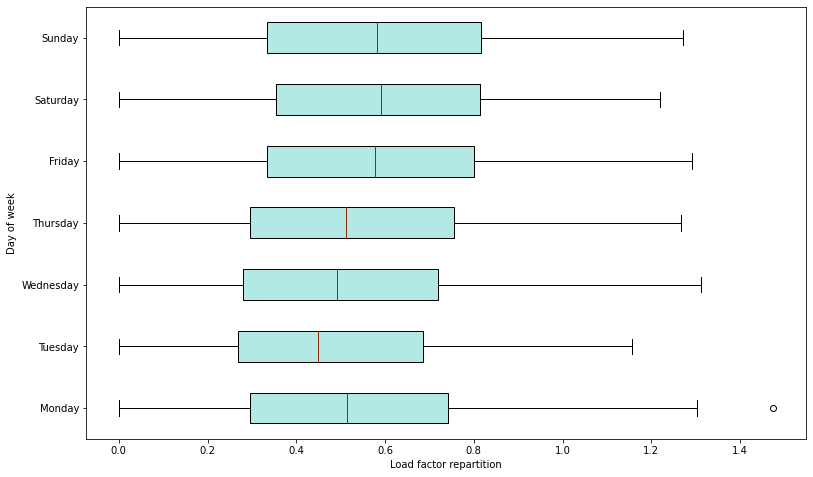

In [13]:
df['weekDay'] = pd.to_datetime(df['ScheduleTime']).dt.weekday
per_weekDay = [None for i in range(7)]

for i in range(7):
    per_weekDay[i] = df[df.weekDay == i]['LoadFactor']


fig = plt.figure(figsize =(10, 6))

ax = fig.add_axes([0, 0, 1, 1])
ax.set_xlabel('Load factor repartition')
ax.set_ylabel('Day of week')
ax.boxplot(per_weekDay, vert=False, patch_artist=True, boxprops=dict(facecolor='#b4e8e5'), medianprops=dict(color='#97260c'))
plt.yticks([k for k in range(1, 8)], ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"])

plt.show()

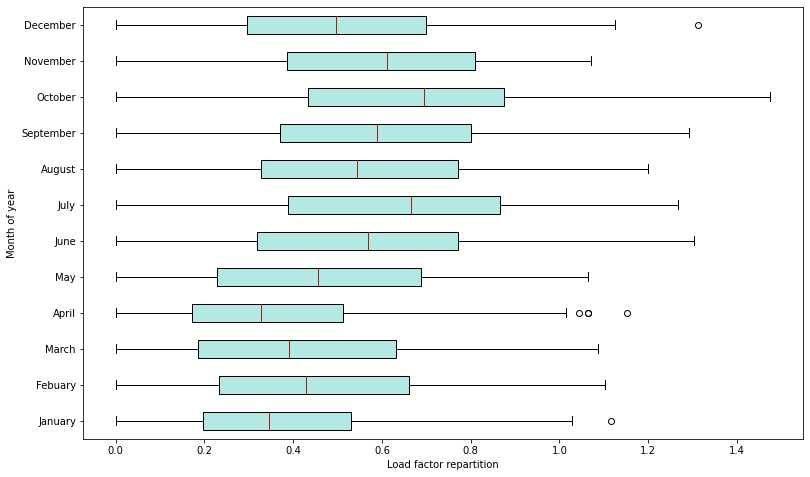

In [14]:
df['month'] = pd.to_datetime(df['ScheduleTime']).dt.month
per_month = [None for i in range(12)]

for i in range(1, 13):
    per_month[i-1] = df[df.month == i]['LoadFactor']


fig = plt.figure(figsize =(10, 6))

ax = fig.add_axes([0, 0, 1, 1])
ax.set_xlabel('Load factor repartition')
ax.set_ylabel('Month of year')
ax.boxplot(per_month, vert=False, patch_artist=True, boxprops=dict(facecolor='#b4e8e5'), medianprops=dict(color='#97260c'))
plt.yticks([k for k in range(1, 13)], ["January", "Febuary", "March", "April", "May", "June", "July", "August", "September", "October", "November", "December"])

plt.show()

         ScheduleTime Airline  FlightNumber Destination  \
0 2021-01-01 06:35:00      IA           874         DEN   
1 2021-01-01 10:35:00      JZ           818         YHM   
2 2021-01-01 12:05:00      IA           876         DEN   
3 2021-01-01 13:20:00      CN           514         EST   
4 2021-01-01 14:20:00      LJ          3140         DEN   

                                        AircraftType FlightType Sector  \
0  0        73W\n1        AT7\n2        73W\n3   ...          J     US   
1  0        73W\n1        AT7\n2        73W\n3   ...          J     CA   
2  0        73W\n1        AT7\n2        73W\n3   ...          J     US   
3  0        73W\n1        AT7\n2        73W\n3   ...          J     US   
4  0        73W\n1        AT7\n2        73W\n3   ...          J     US   

   SeatCapacity  LoadFactor  weekDay  month  
0           142    0.408451        4      1  
1            74    0.189189        4      1  
2           142    0.570423        4      1  
3            72 

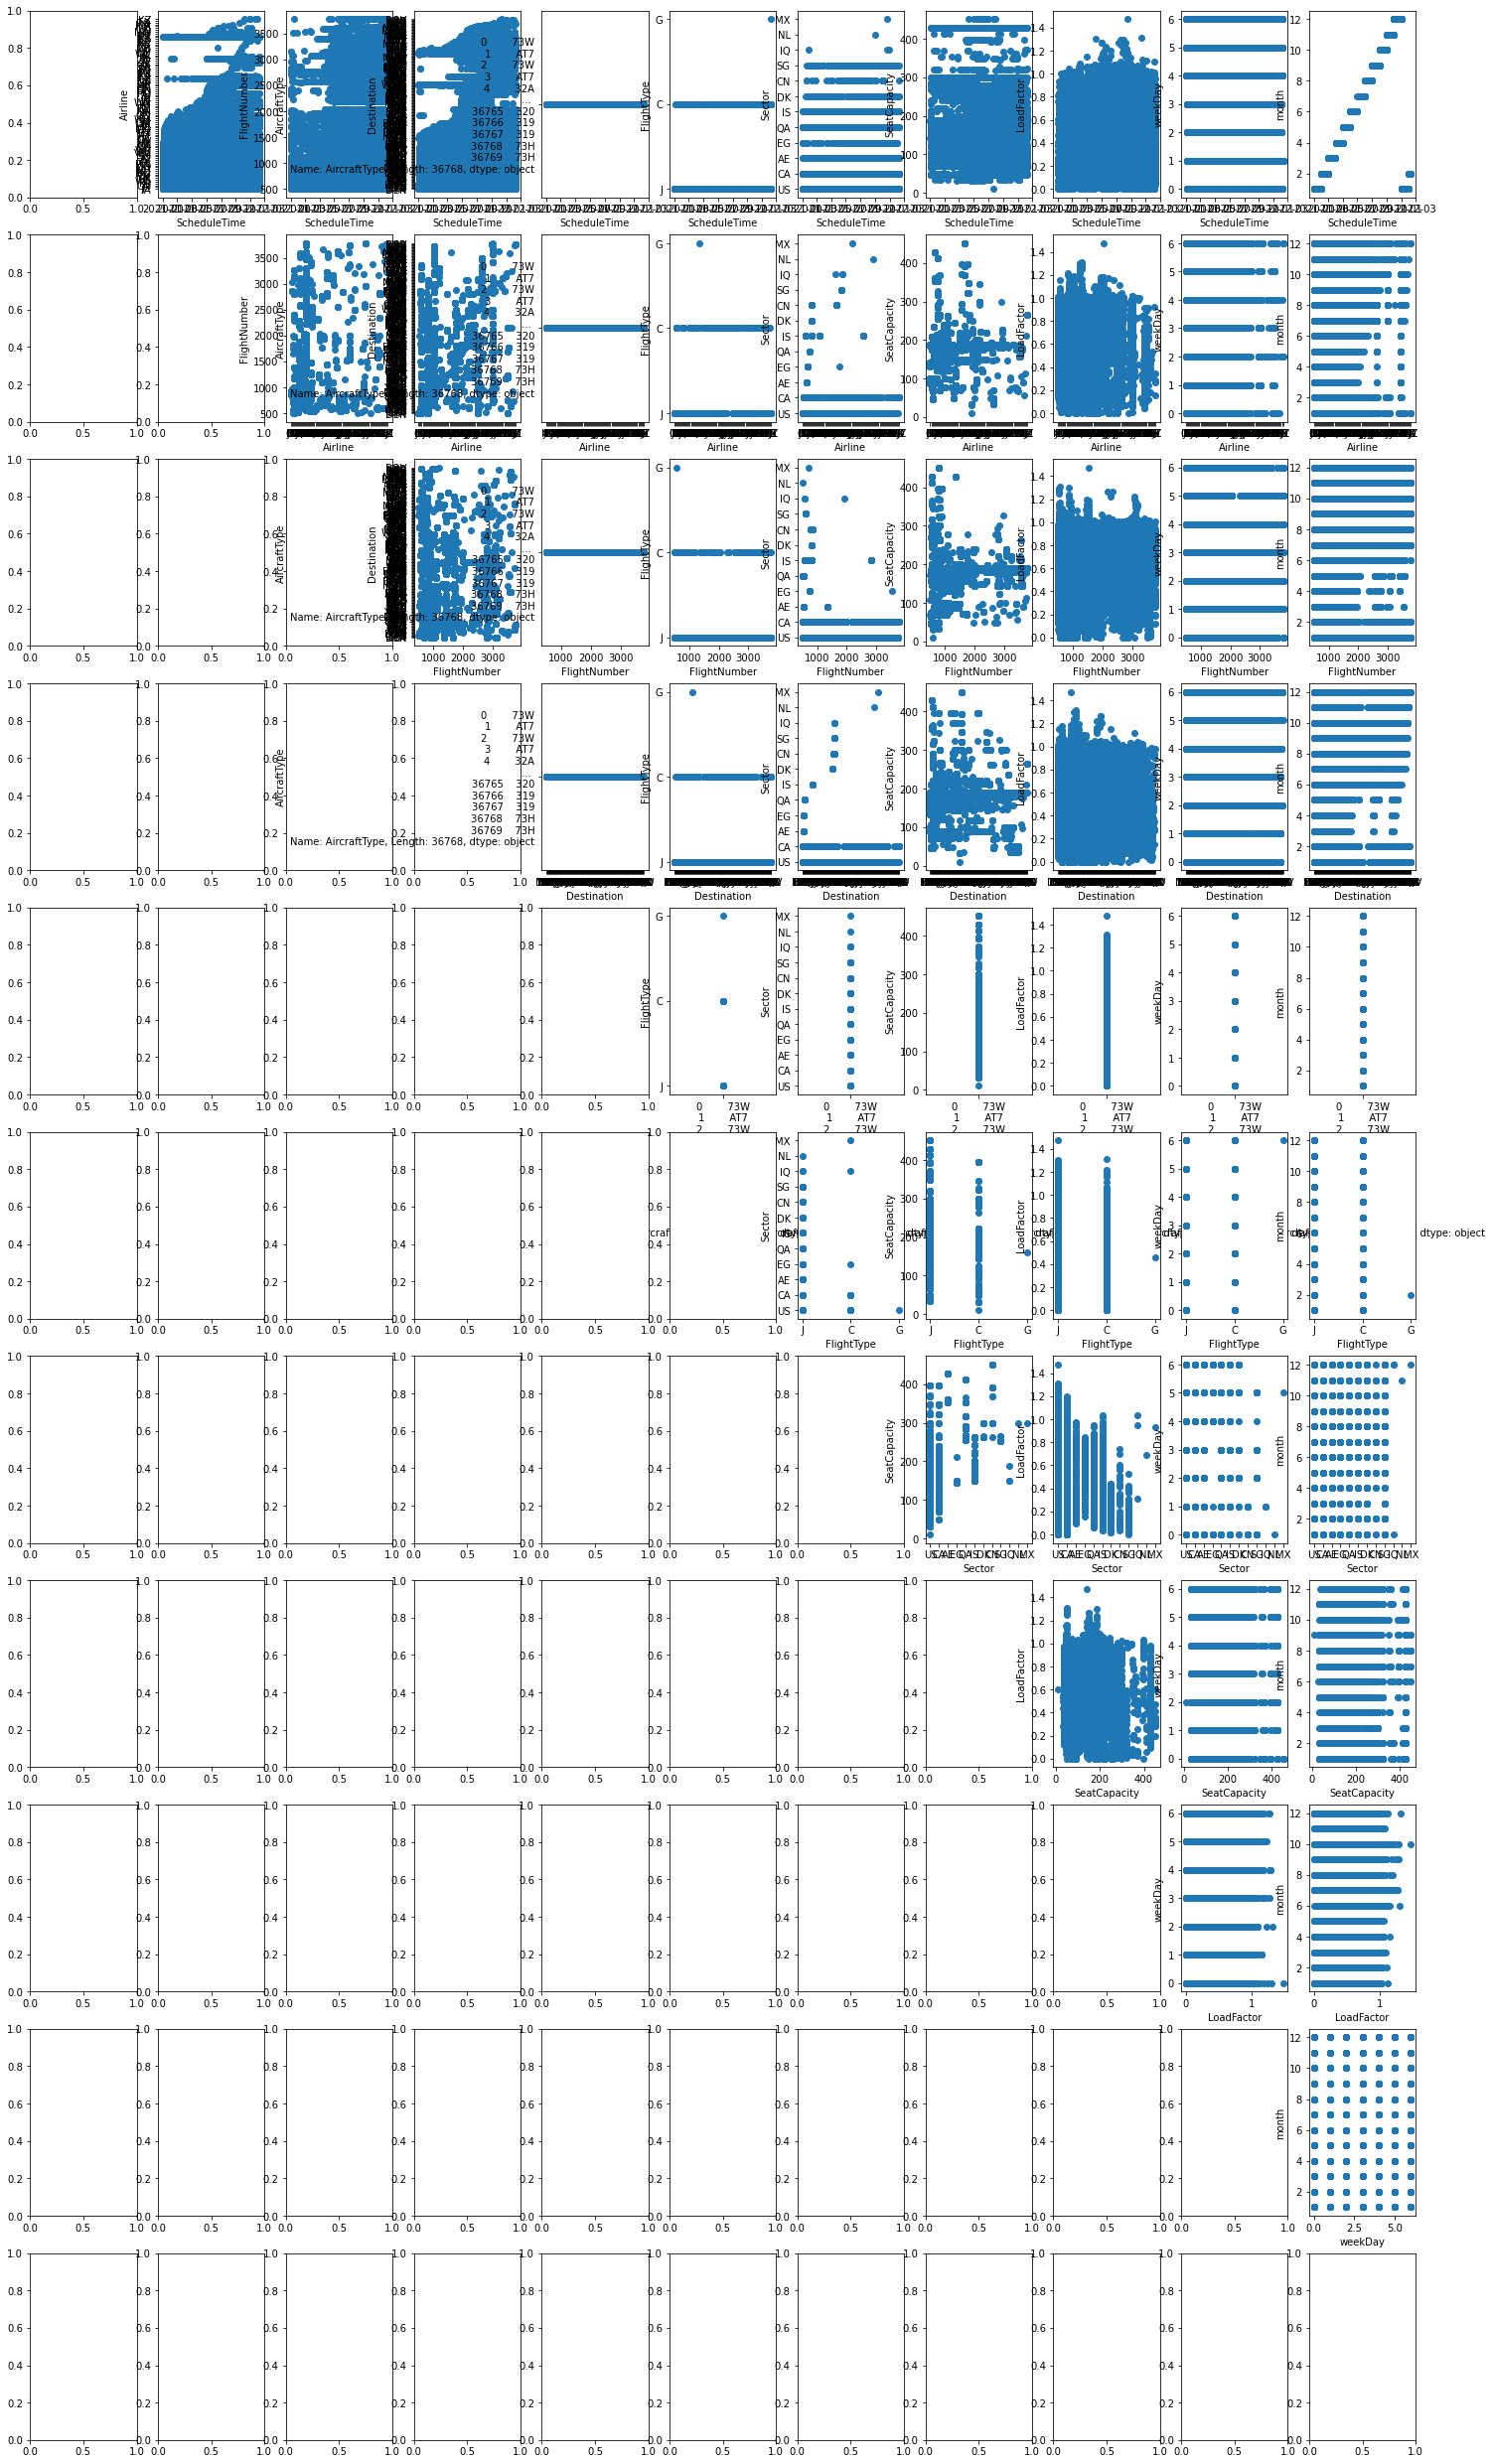

In [15]:
df.AircraftType = str(df.AircraftType)

print(df.head())

cols = list(df.columns)
num_att = len(cols)

print(aircraft)
print(df[df.AircraftType == 339])

print(cols)

print(type(df.loc[0, 'Airline']))
print(type(df.loc[0, 'FlightNumber']))
print(type(df.loc[0, 'Destination']))
print(type(df.loc[0, 'AircraftType']))

fig, axs = plt.subplots(num_att,num_att,figsize=(25, 45))

for i in range(num_att):
    for j in range(i+1, num_att):
        print(cols[i], cols[j])
        axs[i,j].scatter(df[cols[i]], df[cols[j]])
        axs[i,j].set_xlabel(cols[i])
        axs[i,j].set_ylabel(cols[j])


In [17]:
# Exclude the flight with a wrong flight type
df = df[df.FlightType != 'G']

# Extract features and targets
X = df.drop(["LoadFactor", "month", 'weekDay'], axis=1)
y = df.LoadFactor


#Convert schedule time to different columns
# Include month, year, day and weekday in the dataset
X = pd.concat([X, pd.to_datetime(X.ScheduleTime).dt.year.rename("Year")], axis=1)
X = pd.concat([X, pd.to_datetime(X.ScheduleTime).dt.month.rename("Month")], axis=1)
X = pd.concat([X, pd.to_datetime(X.ScheduleTime).dt.week.rename("Week")], axis=1)
X = pd.concat([X, pd.to_datetime(X.ScheduleTime).dt.day.rename("Day")], axis=1)
X = pd.concat([X, pd.to_datetime(X.ScheduleTime).dt.weekday.rename("Weekday")], axis=1)
X = pd.concat([X, pd.to_datetime(X.ScheduleTime).dt.hour.rename("Hour")], axis=1)

# include dummy variables for categorical features
cols = ["Airline", "Destination", "FlightType", "Sector"]
col_prefix = ["AIR", "DEST", "FLT", "SECT"]
weekdays = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]
cols_to_drop = ["FlightNumber", "AircraftType", "ScheduleTime", "Weekday"]

for i, col in enumerate(cols):
    X = pd.concat([X, pd.get_dummies(X[col], prefix=col_prefix[i])], axis=1)

weekday_df = pd.get_dummies(X.Weekday)
weekday_df.columns = weekdays

X = pd.concat([X, weekday_df], axis=1)

X.drop(cols, axis=1, inplace=True)
X.drop(cols_to_drop, axis=1, inplace=True)

print(X.columns)
print(X.shape)



Index(['SeatCapacity', 'Year', 'Month', 'Week', 'Day', 'Hour', 'AIR_AY',
       'AIR_BJ', 'AIR_BT', 'AIR_BZ',
       ...
       'SECT_QA', 'SECT_SG', 'SECT_US', 'Monday', 'Tuesday', 'Wednesday',
       'Thursday', 'Friday', 'Saturday', 'Sunday'],
      dtype='object', length=352)
(36767, 352)


### Decision tree 

In [18]:
print(y)

# Splitting the data into train and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3)

0        0.408451
1        0.189189
2        0.570423
3        0.333333
4        0.204301
           ...   
36765    0.522222
36766    0.532051
36767    0.602564
36768    0.417989
36769    0.497354
Name: LoadFactor, Length: 36767, dtype: float64


In [19]:
dtree = DecisionTreeRegressor()
dtree.fit(X_train, y_train)

pred = dtree.predict(X_val)

print("MSE of decision tree :", mean_squared_error(y_val.to_numpy(), pred))
#print(\"Accuracy score :\", accuracy_score(y_val.to_numpy(), pred))
#print(\"Precision score :\", precision_score(y_val.to_numpy(), pred))
#print(\"Recall score :\", recall_score(y_val.to_numpy(), pred))"

MSE of decision tree : 0.044506623754845494


In [117]:
# Create a linear regression model

model = LinearRegression()
model.fit(X, y)
f_selector = RFE(model, n_features_to_select=0.2, step=1)
f_selector.fit(X, y)
print(f_selector.support_)

TypeError: slice indices must be integers or None or have an __index__ method